In [1228]:
import sys
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import csv

import pandas as pd
import itertools

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



In [1229]:
# Geometry
length = 15e-2              # Length of the rod

# Material properties
rho = 2760.0                      # Density of AL380 (kg/m^3)

k = 109.0                        # W/m-K
                       # W/m-K
cp = 963.0                        # Specific heat of aluminum (J/kg-K)

alpha = k / (rho * cp)            # Thermal diffusivity

# print('alpha ia',alpha)
#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg

# Spatial discretization

num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
# 
time_end = 10               # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
print('dt is ',dt)
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/alpha)
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

dx is 0.003061224489795918
dt is  0.11425342651571017
num_steps is 89
cfl is 0.11425342651571017
stability criteria satisfied


In [1230]:
# Initial Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)


# Initial temperature and phase fields
init_temp = 870.0
temperature = np.full(num_points, init_temp)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

In [1231]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
        
    
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    # print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




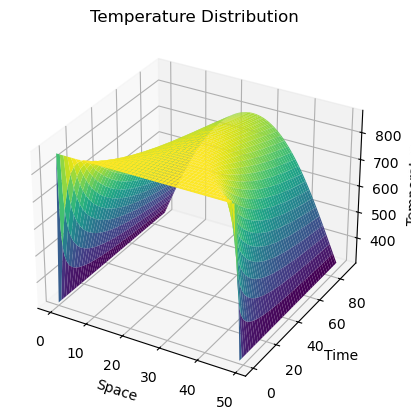

In [1232]:
from mpl_toolkits.mplot3d import Axes3D

temperature_history_a = np.array(temperature_history) 
phi_history_a = np.array(phi_history)

time_steps = temperature_history_a.shape[0]
spatial_poitns = temperature_history_a.shape[1]

time = np.arange(time_steps)
space = np.arange(spatial_poitns)

T,X = np.meshgrid(time,space, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,T,temperature_history_a, cmap='viridis')

ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('Temperature Distribution')

plt.show()

In [1233]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [1234]:

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(HeatPINN, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network


# features = torch.rand(1, 2)
# model = HeatPINN(2, 20, 1)
# output = model(features[:, 0:1], features[:, 1:2])
# print(output)


# Loss function for data 


Preparing the data for Aye Eye

In [1235]:

# Training data preparation
x = torch.linspace(0, length, num_points).view(-1, 1).requires_grad_(True) # Spatial dimension of length l
t = torch.linspace(0, time_end, num_steps+1).view(-1, 1).requires_grad_(True)# Temporal dimension of length T
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') # Create a meshgrid of X and T

X = X.reshape(-1, 1)  # Reshape X to a column vector
T = T.reshape(-1, 1)   # Reshape T to a column vector


In [1236]:



inputs = torch.cat([X, T], dim=1).to(device) # Concatenate the spatial and temporal inputs

temp_t = torch.tensor(np.array(temperature_history)).to(device) # Convert the temperature history to a tensor
# phase_t = torch.tensor(np.array(phi_history)).to(device)         # Convert the phase history to a tensor
temp_inp = temp_t.reshape(-1,1) # Reshape the temperature tensor to a column vector
# phase_inp = phase_t.reshape(-1,1) # Reshape the temperature tensor to a column vector


#Data Splitting

train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)
val_inputs, test_inputs, val_temp_inp, test_temp_inp = train_test_split(val_test_inputs, val_test_temp_inp, test_size=0.5, random_state=42)

# print(type(train_inputs)) 
# print(type(val_inputs))
# print(type(test_inputs))
# print(type(train_temp_inp))
# print(type(val_temp_inp))
# print(type(test_temp_inp))



Create the custom data set for the training from 

In [1237]:


class  SpatiotemporalDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp, transform = None, target_transform = None):
        self.inputs = inputs
        self.temp_inp = temp_inp
        

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index]

    def __len__(self):
        return len(self.inputs)

# Create the dataset and dataloader   

train_dataset = SpatiotemporalDataset(train_inputs, train_temp_inp)

val_dataset = SpatiotemporalDataset(val_inputs, val_temp_inp)
test_dataset = SpatiotemporalDataset(test_inputs, test_temp_inp)


train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)



In [1238]:
def pde_loss(u_pred,x,t,alpha):
    
    u_t = torch.autograd.grad(u_pred, t, 
                                torch.ones_like(u_pred).to(device), 
                                create_graph=True, 
                                allow_unused=True
                                )[0] # Calculate the first time derivative


    u_x = torch.autograd.grad(u_pred, 
                                x, 
                                torch.ones_like(u_pred).to(device), 
                                create_graph=True,
                                allow_unused =True)[0] # Calculate the first space derivative
            
    u_xx = torch.autograd.grad(u_x, 
                                x, 
                                torch.ones_like(u_x).to(device), 
                                create_graph=True,
                                allow_unused=True)[0] 
    
    residual = u_t - alpha * u_xx
    return nn.MSELoss()(residual,torch.zeros_like(residual))

def boundary_loss(u_left,u_right,boundary_value):
    return torch.mean((u_left - boundary_value)**2 + (u_right - boundary_value)**2)

def initial_condition_loss(u_initial,initial_value):
    return torch.mean((u_initial - initial_value)**2)


def loss_fn_data(u_pred, u_true):
    return nn.MSELoss()(u_pred, u_true)

def l1_regularization(model, lambda_):
    l1_reg = sum(param.abs().sum() for param in model.parameters())
    return l1_reg

In [1239]:
# Hyperparameters
hidden_size = 300
learning_rate = 0.09
epochs = 30000
# alpha = 0.01  # Adjust this value based on your problem
boundary_value = 313.0
initial_value = init_temp
# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1).to(device)
lambda_l1 = 0.2

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Training Function

In [1240]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, val_dataloader,test_dataloader):
    train_losses = []  # Initialize the list to store the training losses
    val_losses = []    # Initialize the list to store the validation losses
    test_losses = []   # Initialize the list to store the test losses
    for epoch in range(epochs):
        model.train()                 # Set the model to training mode
        train_loss = 0                # Initialize the training loss

        for batch in train_dataloader:              # Loop through the training dataloader
            
            inputs, temp_inp = batch                 # Get the inputs and the true values
            inputs, temp_inp = inputs.to(device), temp_inp.to(device) # Move the inputs and true values to the GPU
            
            inputs= inputs.clone().detach().requires_grad_(True)
            temp_inp= temp_inp.clone().requires_grad_(True)

            optimizer.zero_grad()                               # Zero the gradients
            
        
            x = inputs[:,0].unsqueeze(1)
           
            t = inputs[:,1].unsqueeze(1)
            
            # Forward pass
            u_pred = model(x,t).to(device) # Get the predictions
           
            
            
            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp.float()) # Calculate the data loss
            residual_loss = pde_loss(u_pred, x, t, alpha) # Calculate the PDE loss
            boundary_loss_val = boundary_loss(u_pred[0], u_pred[-1], boundary_value)
            initial_loss = initial_condition_loss(u_pred[0], initial_value) # Calculate the initial condition loss

            total_loss = residual_loss + data_loss +boundary_loss_val + initial_loss # Calculate the total loss
            
            # Backpropagation
            total_loss.backward(retain_graph=True)                             # Backpropagate the gradients
            
            optimizer.step()                                                   # Update the weights
            
            train_loss += total_loss.item()     
                                        # Add the loss to the training set loss
        train_losses.append(train_loss)                               # Append the training loss to the list of training losses
        
       
        
        model.eval()
        val_loss = 0                                                                     # Initialize the validation loss
        
        with torch.no_grad():
            for batch in val_dataloader:                                                            # Loop through the validation dataloader
                inputs, temp_inp= batch                                                        # Get the inputs and the true values
                inputs, temp_inp= inputs.to(device), temp_inp.to(device)                                     # Move the inputs and true values to the GPU
                u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))                        # Get the predictions
                data_loss = loss_fn_data(u_pred, temp_inp.float())                                          # Calculate the data loss
                loss = data_loss                                                                          # Calculate the total loss
                val_loss += loss.item()                                                                     # Add the loss to the validation set loss
            val_losses.append(val_loss)                                                                 # Append the validation loss to the list of validation losses
            
                                                                                                         # Append the validation loss to the list of validation losses
        
        model.eval()
        test_loss = 0                                                                     # Initialize the validation loss
        with torch.no_grad():   
            for batch in test_dataloader:
                inputs, temp_inp= batch
                inputs, temp_inp= inputs.to(device), temp_inp.to(device)
                u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
                data_loss = loss_fn_data(u_pred, temp_inp.float())
                loss = data_loss 
                test_loss += loss.item()
            test_losses.append(test_loss)

            if epoch %10 ==0:
                print(f"Epoch{epoch},Training-Loss {train_loss:.4e}, Val-losses {val_loss:.4e}, Test-losses {test_loss:.4e}") 

    return train_losses, val_losses, test_losses                                                                   # Return the training and validation losses


Validation Function

In [1241]:
# def test_loop(model, loss_fn_data, test_dataloader):
       
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():   
#         for batch in test_dataloader:
#             inputs, temp_inp= batch
#             inputs, temp_inp= inputs.to(device), temp_inp.to(device)
#             u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
#             data_loss = loss_fn_data(u_pred, temp_inp.float())
#             loss = data_loss 
#             test_loss += loss.item()
#         test_losses.append(test_loss)
#     if epochs % 10 == 0:
#         print(f"Epoch {epochs}, Test-Loss {test_loss}")    
#     return test_losses

In [1242]:

train_losses,val_losses,test_losses = training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, val_dataloader,test_dataloader)  # Train the model
 


# train_losses.append(train_losses)

# test_losses.append(test_losses)

   


    
    

Epoch0,Training-Loss 7.2998e+09, Val-losses 1.2373e+06, Test-losses 1.2335e+06
Epoch10,Training-Loss 4.8866e+07, Val-losses 1.3975e+06, Test-losses 1.3518e+06
Epoch20,Training-Loss 4.8509e+07, Val-losses 1.1872e+06, Test-losses 1.1684e+06
Epoch30,Training-Loss 4.8823e+07, Val-losses 1.3678e+06, Test-losses 1.3075e+06
Epoch40,Training-Loss 4.8479e+07, Val-losses 1.3672e+06, Test-losses 1.3462e+06
Epoch50,Training-Loss 4.8065e+07, Val-losses 1.2018e+06, Test-losses 1.1873e+06
Epoch60,Training-Loss 4.8066e+07, Val-losses 1.1978e+06, Test-losses 1.1834e+06
Epoch70,Training-Loss 4.8067e+07, Val-losses 1.1990e+06, Test-losses 1.1846e+06
Epoch80,Training-Loss 4.8069e+07, Val-losses 1.1607e+06, Test-losses 1.1471e+06
Epoch90,Training-Loss 4.8072e+07, Val-losses 1.1822e+06, Test-losses 1.1681e+06
Epoch100,Training-Loss 4.8080e+07, Val-losses 1.1829e+06, Test-losses 1.1688e+06
Epoch110,Training-Loss 4.8090e+07, Val-losses 1.1973e+06, Test-losses 1.1829e+06
Epoch120,Training-Loss 4.8097e+07, Val-

In [1243]:
print('Training Losses:', train_losses)
print('Validation Losses:', val_losses)
print('Test Losses:', test_losses)

Training Losses: [7299768626.03125, 49067558.21875, 48847871.453125, 48771780.15625, 48767311.1875, 48696548.96875, 48771089.765625, 48658491.84375, 49366237.640625, 48734613.328125, 48865868.6875, 49014151.9375, 48643458.6875, 48877477.546875, 48710096.640625, 49001336.859375, 48669629.9375, 49194851.9375, 49121561.640625, 49116469.78125, 48508562.9375, 48750351.96875, 48797381.59375, 48722764.625, 49202838.703125, 49108236.203125, 48500545.1875, 48740212.234375, 49228989.796875, 49242708.375, 48822949.5, 48960516.46875, 49263848.921875, 48701423.828125, 48683994.25, 48787387.84375, 50329916.0625, 48631282.078125, 48257155.734375, 48330036.984375, 48478658.53125, 48405180.828125, 48317801.890625, 48285861.6875, 48286317.546875, 48124842.234375, 48308829.734375, 83422469767992.52, 50706847.4375, 48065125.15625, 48065218.828125, 48065655.0, 48065564.203125, 48065395.765625, 48066934.515625, 48064980.75, 48066029.765625, 48065701.21875, 48066169.84375, 48066794.71875, 48065994.203125, 48

In [1244]:
# torch.save(model.state_dict(), 'model.pth')

# # Load the model
# model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1).to(device)
# model.load_state_dict(torch.load('model.pth'))
# model.to(device)

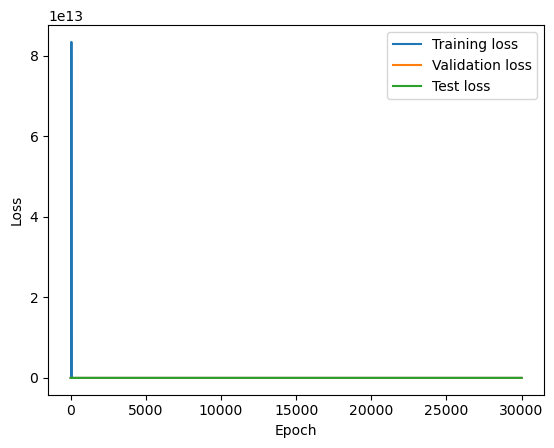

In [1245]:


 #plotting the loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()